### Data import

In [1]:
import pandas as pd

In [3]:
df1= pd.read_csv("./data/Youtube05.csv")
df2= pd.read_csv("./data/Youtube01.csv")
df3= pd.read_csv("./data/Youtube03.csv")
df4= pd.read_csv("./data/Youtube02.csv")
df5= pd.read_csv("./data/Youtube04.csv")

In [4]:
data= pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
dataset= data[["CONTENT", "CLASS"]]
comments= data[["CONTENT"]]
y_test = data["CLASS"]

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset['CONTENT'], dataset['CLASS'], test_size=0.2, random_state=42, stratify=dataset['CLASS'])

x_train = {'CONTENT': x_train,'CLASS': y_train}
x_train= pd.DataFrame(x_train)
x_test= {'CONTENT': x_test, 'CLASS': y_test}
x_test= pd.DataFrame(x_test)

### Defining labeling functions using Snorkel

In [6]:
# Possible labeling outputs defined
ABSTAIN = -1
HAM = 0
SPAM = 1

### Pattern Matching Labeling Functions

In [7]:
from snorkel.labeling import labeling_function

# check and check_out labeling functions return SPAM for texts that include those key words

@labeling_function()
def check(x):
    return SPAM if "check" in x.CONTENT.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.CONTENT.lower() else ABSTAIN

In [8]:
import re

@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.CONTENT, flags=re.I) else ABSTAIN

In [9]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.CONTENT.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe", "subscribers", "sub", "subs"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

"""spam comments ask for some sort of help"""
keyword_help= make_keyword_lf(keywords=['help'])

keyword_channel= make_keyword_lf(keywords=['channel'])

### Heuristic Labeling Functions

In [10]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.CONTENT.split()) < 5 else ABSTAIN

### Third Party Model as Labeling Functions

In [11]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.CONTENT)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [12]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

### Labeling Functions with Complex Pre-Processors

In [13]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="CONTENT", doc_field="doc", memoize=True)

from snorkel.labeling.lf.nlp import nlp_labeling_function

@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

/home/amy/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-21 09:35:00.913902: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 09:35:00.947701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 09:35:01.550729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

In [14]:
print(x_train.to_string)

<bound method DataFrame.to_string of                                                 CONTENT  CLASS
225                                           Waka waka      0
879                                     Wow dance show﻿      0
25    Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...      0
1384  Plz help me getting 1.000 Subscribers tonight/...      1
690   If the shitty Chinese Government didn't block ...      0
...                                                 ...    ...
239                                                  :)      0
1413  Www.youniqueproducts.com/joannagordon Younique...      1
300   Hello everyone :) I know most of you probably ...      1
623   I am now going to voyage to the first comment....      0
1844  I agree they are just damn spammers. They suck...      1

[1564 rows x 2 columns]>


### Combining labeling function outputs with label model

In [15]:
lfs = [check,
    check_out,
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    keyword_help,
    keyword_channel,
    regex_check_out,
    short_comment,
    has_person,
    textblob_polarity,
    textblob_subjectivity,
]

In [16]:
from snorkel.labeling import PandasLFApplier

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=x_train)
L_test = applier.apply(df=x_test)

100%|██████████| 392/392 [00:02<00:00, 185.45it/s]


In [17]:
print(L_train)
L_train.shape

[[-1 -1 -1 ...  0 -1 -1]
 [-1 -1 -1 ... -1 -1  0]
 [-1 -1 -1 ... -1 -1  0]
 ...
 [ 1  1  1 ... -1 -1  0]
 [-1 -1  1 ... -1 -1  0]
 [-1 -1 -1 ... -1 -1 -1]]


(1564, 14)

In [18]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check,0,[1],0.245524,0.240409,0.102941
check_out,1,[1],0.205882,0.205882,0.078645
keyword_my,2,[1],0.200767,0.195652,0.123402
keyword_subscribe,3,[1],0.143223,0.126598,0.081202
keyword_http,4,[1],0.092711,0.081202,0.065857
keyword_please,5,[1],0.111893,0.107417,0.059463
keyword_song,6,[0],0.166880,0.137468,0.053708
keyword_help,7,[1],0.030691,0.028772,0.015345
keyword_channel,8,[1],0.101023,0.100384,0.056905
regex_check_out,9,[1],0.224425,0.224425,0.090793


In [19]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [20]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.502]


INFO:root:[100 epochs]: TRAIN:[loss=0.028]
 39%|███▉      | 196/500 [00:00<00:00, 1957.76epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.028]
INFO:root:[300 epochs]: TRAIN:[loss=0.028]
INFO:root:[400 epochs]: TRAIN:[loss=0.028]
100%|██████████| 500/500 [00:00<00:00, 2189.29epoch/s]
INFO:root:Finished Training


In [21]:
majority_acc = majority_model.score(L=L_test, Y=y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   83.2%
Label Model Accuracy:     74.7%


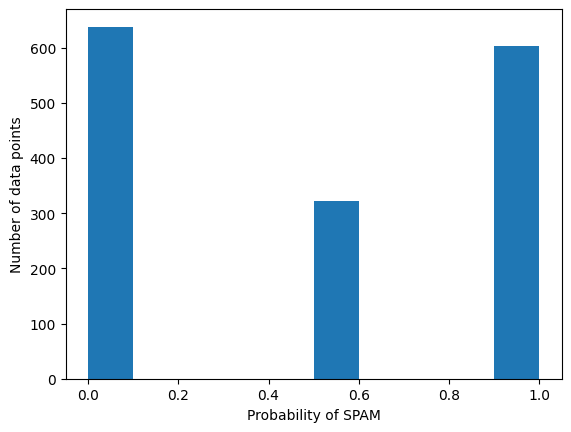

In [22]:
import matplotlib.pyplot as plt

def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = majority_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

In [23]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=x_train, y=probs_train, L=L_train
)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.CONTENT.tolist())
X_test = vectorizer.transform(x_test.CONTENT.tolist())

In [25]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [26]:
df_train_filtered

,CONTENT,CLASS
225,Waka waka,0
879,Wow dance show﻿,0
25,Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0
1384,Plz help me getting 1.000 Subscribers tonight/...,1
1029,Can i get views and subscribers for no reason? 😅﻿,1
...,...,...
239,:),0
1413,Www.youniqueproducts.com/joannagordon Younique...,1
300,Hello everyone :) I know most of you probably ...,1
623,I am now going to voyage to the first comment....,0


In [27]:
len(preds_train_filtered)
df_train_filtered['LABEL']= preds_train_filtered
df_train_filtered= df_train_filtered.reset_index(drop=True)
df_train_filtered

/tmp/ipykernel_840/580693601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered['LABEL']= preds_train_filtered


,CONTENT,CLASS,LABEL
0,Waka waka,0,0
1,Wow dance show﻿,0,0
2,Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,Plz help me getting 1.000 Subscribers tonight/...,1,1
4,Can i get views and subscribers for no reason? 😅﻿,1,1
...,...,...,...
1386,:),0,0
1387,Www.youniqueproducts.com/joannagordon Younique...,1,0
1388,Hello everyone :) I know most of you probably ...,1,1
1389,I am now going to voyage to the first comment....,0,0


In [28]:
x_testing= x_test.reset_index(drop=True)
x_testing

,CONTENT,CLASS
0,This is the only video on youtube that get so ...,0
1,I love dis song!! 3,0
2,EMINEM the best EVER.﻿,0
3,Cutie girl and beautiful song,0
4,Hey youtubers... I really appreciate all of yo...,1
...,...,...
387,How old is Katy perry?﻿,0
388,2015!! LLIKEE!!﻿,0
389,Hey guys! Please join me in my fight to help a...,1
390,waka waka:-):-):-)﻿,0


### Training an end model/classifier with weak labels

#### Training Simple Logistic Regression classifier

In [29]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [30]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=y_test) * 100:.1f}%")

Test Accuracy: 85.5%


#### Data cleaning

In [31]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import numpy as np
import pickle
from keras.utils import pad_sequences

[nltk_data] Downloading package stopwords to /home/amy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/amy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/amy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
df_train_filtered.dropna()

,CONTENT,CLASS,LABEL
0,Waka waka,0,0
1,Wow dance show﻿,0,0
2,Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,Plz help me getting 1.000 Subscribers tonight/...,1,1
4,Can i get views and subscribers for no reason? 😅﻿,1,1
...,...,...,...
1386,:),0,0
1387,Www.youniqueproducts.com/joannagordon Younique...,1,0
1388,Hello everyone :) I know most of you probably ...,1,1
1389,I am now going to voyage to the first comment....,0,0


In [33]:
def clean_text(text):
    text_cleaning_re= "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text= re.sub(text_cleaning_re, " " , str(text).lower()).strip()
    tokens= text.split()
    stop_words= set(stopwords.words('english'))
    tokens= [w for w in tokens if w not in stop_words]

    return " ".join(tokens)

In [34]:
print("cleaning training data...")
df_train_filtered.CONTENT= df_train_filtered.CONTENT.apply(lambda x: clean_text(x))
print("cleaning testing data...")
x_testing.CONTENT= x_testing.CONTENT.apply(lambda x: clean_text(x))

cleaning training data...
cleaning testing data...


In [35]:
df_train_filtered.CONTENT.replace("", np.nan, inplace=True)
df_train_filtered.dropna(subset=['CONTENT'], inplace=True)
df_train_filtered

,CONTENT,CLASS,LABEL
0,waka waka,0,0
1,wow dance show,0,0
2,nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,plz help getting 1 000 subscribers tonight tod...,1,1
4,get views subscribers reason,1,1
...,...,...,...
1385,awesome,0,0
1387,www youniqueproducts com joannagordon younique...,1,0
1388,hello everyone know probably pass kind comment...,1,1
1389,going voyage first comment tell family loved,0,0


In [36]:
df_train_filtered.CONTENT = df_train_filtered.CONTENT.fillna('')

In [37]:
def tokenize(text):
    tokens= nltk.word_tokenize(text)
    return [w for w in tokens if w.isalpha()]

In [38]:
df_train_filtered['CONTENT']= df_train_filtered.apply(lambda x: tokenize(x['CONTENT']), axis=1)
x_testing['CONTENT']= x_testing.apply(lambda x: tokenize(x['CONTENT']), axis=1)

In [39]:
def rejoin_words(tokenized_column):
    return (" ".join(tokenized_column))

In [40]:
df_train_filtered['CONTENT']= df_train_filtered.apply(lambda x: rejoin_words(x['CONTENT']), axis=1)
x_testing['CONTENT']= x_testing.apply(lambda x: rejoin_words(x['CONTENT']), axis=1)

In [41]:
df_train_filtered

,CONTENT,CLASS,LABEL
0,waka waka,0,0
1,wow dance show,0,0
2,nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkk...,0,0
3,plz help getting subscribers tonight today tha...,1,1
4,get views subscribers reason,1,1
...,...,...,...
1385,awesome,0,0
1387,www youniqueproducts com joannagordon younique...,1,0
1388,hello everyone know probably pass kind comment...,1,1
1389,going voyage first comment tell family loved,0,0


In [42]:
x_testing

,CONTENT,CLASS
0,video youtube get much views want see much vie...,0
1,love dis song,0
2,eminem best ever,0
3,cutie girl beautiful song,0
4,hey youtubers really appreciate took time read...,1
...,...,...
387,old katy perry,0
388,llikee,0
389,hey guys please join fight help abused mistrea...,1
390,waka waka,0


In [43]:
df_train_filtered['CONTENT'].replace('', np.nan, inplace=True)
print("there is " +str(df_train_filtered.isna().sum().sum()) + "instance of null values within the dataset")
x_testing['CONTENT'].replace('', np.nan, inplace=True)
print("there is " +str(x_testing.isna().sum().sum()) + "instance of null values within the dataset")

there is 6instance of null values within the dataset
there is 11instance of null values within the dataset


In [44]:
df_train_filtered.dropna(inplace=True)
x_testing.dropna(inplace=True)

In [45]:
df_train_filtered.isna().sum()
x_testing.isna().sum()

CONTENT    0
CLASS      0
dtype: int64

In [46]:
weak_labels= pd.get_dummies(df_train_filtered['LABEL']).values
y_test= pd.get_dummies(x_testing['CLASS']).values

In [47]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(df_train_filtered.CONTENT)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
max_length= max([len(s.split()) for s in df_train_filtered.CONTENT])

x_train= pad_sequences(tokenizer.texts_to_sequences(df_train_filtered.CONTENT), maxlen= max_length, padding= 'post', truncating= 'post')

x_test= pad_sequences(tokenizer.texts_to_sequences(x_testing.CONTENT), maxlen=max_length, padding='post', truncating='post')

word_index= tokenizer.word_index

print(x_train.shape)
print(x_test.shape)

(1336, 93)
(381, 93)


In [49]:
def load_embedding(file_name):
    file= open(file_name, 'r', encoding='utf-8')
    lines= file.readlines()
    file.close()

    embedding= dict()
    for line in lines:
        parts= line.split()
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

vocab= word_index
vocab_size= len(word_index)+ 1
embedding_dim= 100

raw_embedding= load_embedding('./data/glove.twitter.27B.100d.txt')

In [50]:
def get_weight_matrix(embedding, vocab):
    vocab_size= len(vocab)+1
    weight_matrix= np.zeros((vocab_size, embedding_dim))

    for word, i in vocab.items():
        vector= embedding.get(word)
        if vector is not None:
            weight_matrix[i]= vector
    return weight_matrix

embedding_matrix= get_weight_matrix(raw_embedding, vocab)

#### Training Bi-LSTM

In [51]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM, SpatialDropout1D, Bidirectional
from keras.layers.core import Dense, Dropout

In [52]:
embedding_layer= Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)

In [53]:
biLSTM= Sequential()
biLSTM.add(embedding_layer)
biLSTM.add(Bidirectional(LSTM(64, return_sequences=True)))
biLSTM.add(Bidirectional(LSTM(64)))
biLSTM.add(Dense(32))
biLSTM.add(Dense(32))
biLSTM.add(Dense(32))
biLSTM.add(Dense(2, activation= 'sigmoid'))

biLSTM.summary()

2023-06-21 09:37:32.856064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 09:37:32.857373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 09:37:32.858390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 93, 100)           274600    
                                                                 
 bidirectional (Bidirectiona  (None, 93, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1

2023-06-21 09:37:33.098246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 09:37:33.099701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 09:37:33.100611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [54]:
Batch_size= 32
epochs=10

biLSTM.compile(loss= 'binary_crossentropy', optimizer= 'Adam', metrics= 'accuracy')

In [55]:
history= biLSTM.fit(x_train, weak_labels, batch_size= Batch_size, epochs=10, verbose=1)

Epoch 1/10


2023-06-21 09:37:39.860154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 09:37:39.862671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 09:37:39.863757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 7s 64ms/step - loss: 0.3944 - accuracy: 0.8316
Epoch 2/10
42/42 [==============================] - 3s 64ms/step - loss: 0.2528 - accuracy: 0.9072
Epoch 3/10
42/42 [==============================] - 3s 66ms/step - loss: 0.2159 - accuracy: 0.9266
Epoch 4/10
42/42 [==============================] - 3s 64ms/step - loss: 0.1765 - accuracy: 0.9386
Epoch 5/10
42/42 [==============================] - 3s 66ms/step - loss: 0.1558 - accuracy: 0.9476
Epoch 6/10
42/42 [==============================] - 3s 70ms/step - loss: 0.1422 - accuracy: 0.9573
Epoch 7/10
42/42 [==============================] - 3s 73ms/step - loss: 0.1191 - accuracy: 0.9596
Epoch 8/10
42/42 [==============================] - 3s 76ms/step - loss: 0.1130 - accuracy: 0.9626
Epoch 9/10
42/42 [==============================] - 3s 71ms/step - loss: 0.1162 - accuracy: 0.9581
Epoch 10/10
42/42 [==============================] - 3s 72ms/step - loss: 0.0916 - accuracy: 0.9663


In [55]:
results= biLSTM.evaluate(x_test, y_test)

2023-06-19 16:54:01.451743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 16:54:01.453701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 16:54:01.455127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 2s 41ms/step - loss: 0.4518 - accuracy: 0.9029


In [56]:
biLSTM2= Sequential()
biLSTM2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
biLSTM2.add(Bidirectional(LSTM(64, return_sequences=True)))
biLSTM2.add(Bidirectional(LSTM((64))))
biLSTM2.add(Dense(32))
biLSTM2.add(Dense(32))
biLSTM2.add(Dense(32))
biLSTM2.add(Dense(2, activation= 'sigmoid'))

biLSTM2.summary()

2023-06-19 16:55:17.433459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 16:55:17.434587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 16:55:17.437583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 93, 100)           274600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 93, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)               

In [57]:
biLSTM2.compile(loss='binary_crossentropy', optimizer='Adam', metrics= ['accuracy'])

In [58]:
history2= biLSTM2.fit(x_train, weak_labels, batch_size= Batch_size, epochs=10, verbose=1)

Epoch 1/10


2023-06-19 16:55:20.298130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 16:55:20.302692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 16:55:20.305638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 10s 98ms/step - loss: 0.5184 - accuracy: 0.7380
Epoch 2/10
42/42 [==============================] - 4s 97ms/step - loss: 0.1919 - accuracy: 0.9274
Epoch 3/10
42/42 [==============================] - 4s 96ms/step - loss: 0.0910 - accuracy: 0.9641
Epoch 4/10
42/42 [==============================] - 4s 101ms/step - loss: 0.0428 - accuracy: 0.9858
Epoch 5/10
42/42 [==============================] - 5s 110ms/step - loss: 0.0280 - accuracy: 0.9880
Epoch 6/10
42/42 [==============================] - 5s 110ms/step - loss: 0.0329 - accuracy: 0.9895
Epoch 7/10
42/42 [==============================] - 5s 110ms/step - loss: 0.0356 - accuracy: 0.9880
Epoch 8/10
42/42 [==============================] - 5s 110ms/step - loss: 0.0207 - accuracy: 0.9910
Epoch 9/10
42/42 [==============================] - 5s 108ms/step - loss: 0.0196 - accuracy: 0.9933
Epoch 10/10
42/42 [==============================] - 4s 101ms/step - loss: 0.0222 - accuracy: 0.9910


In [59]:
results2= biLSTM.evaluate(x_test, y_test)

12/12 [==============================] - 1s 42ms/step - loss: 0.4518 - accuracy: 0.9029


#### Training BERT

In [60]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [86]:
bert_preprocess= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder= hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2023-06-19 17:40:14.491129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-19 17:40:14.492471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-19 17:40:14.492729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-19 17:40:14.493990: I tensorflow/core/

In [87]:
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text= bert_preprocess(text_input)
outputs= bert_encoder(preprocessed_text)

2023-06-19 17:41:06.037448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-06-19 17:41:06.055935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-06-19 17:41:06.106940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-06-19 1

In [88]:
x = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
x = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(x)

In [89]:
model = tf.keras.Model(inputs=[text_input], outputs = [x])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [90]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [91]:
X_train= df_train_filtered['CONTENT']
Y_train= df_train_filtered['LABEL']

model.fit(X_train, Y_train, epochs=20)

Epoch 1/20


2023-06-19 17:41:14.543794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3}}]]
2023-06-19 17:41:14.543899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4}}]]
2023

42/42 [==============================] - 127s 3s/step - loss: 0.7122 - accuracy: 0.5442
Epoch 2/20
42/42 [==============================] - 123s 3s/step - loss: 0.6559 - accuracy: 0.6213
Epoch 3/20
42/42 [==============================] - 125s 3s/step - loss: 0.6134 - accuracy: 0.7043
Epoch 4/20
42/42 [==============================] - 125s 3s/step - loss: 0.5860 - accuracy: 0.7148
Epoch 5/20
42/42 [==============================] - 124s 3s/step - loss: 0.5688 - accuracy: 0.7223
Epoch 6/20
42/42 [==============================] - 124s 3s/step - loss: 0.5488 - accuracy: 0.7657
Epoch 7/20
42/42 [==============================] - 123s 3s/step - loss: 0.5317 - accuracy: 0.7814
Epoch 8/20
42/42 [==============================] - 122s 3s/step - loss: 0.5214 - accuracy: 0.7844
Epoch 9/20
42/42 [==============================] - 119s 3s/step - loss: 0.5097 - accuracy: 0.7852
Epoch 10/20
42/42 [==============================] - 119s 3s/step - loss: 0.5079 - accuracy: 0.7807
Epoch 11/20
42/42 [=

In [92]:
X_test= x_testing['CONTENT']
Y_test= x_testing['CLASS']

model.evaluate(X_test, Y_test)

12/12 [==============================] - 35s 3s/step - loss: 0.4221 - accuracy: 0.8478


[0.4221039116382599, 0.847769021987915]